### Dependencies to Install / Initial Checks





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip3 install datasets
!pip install numpy
!pip install sentence_transformers
!pip install --upgrade torch torchvision torchaudio
!pip install --upgrade transformers sentence-transformers
!pip install -U accelerate
!pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 

In [ ]:
import torch
from datasets import Dataset
from sentence_transformers import (
    SentenceTransformer,
    SentenceTransformerTrainer,
    SentenceTransformerTrainingArguments,
    SentenceTransformerModelCardData,
)
from sentence_transformers.losses import MultipleNegativesRankingLoss, AnglELoss
from sentence_transformers.training_args import BatchSamplers, ParallelMode
from sentence_transformers.evaluation import TripletEvaluator
import accelerate
import os

In [ ]:
!nvidia-smi

Fri Jul  5 22:13:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              50W / 400W |  12051MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
# Make Sure GPU Instance is Working
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    try:
        x = torch.tensor([1.0, 2.0, 3.0], device='cuda')
        print(f"Tensor on CUDA: {x}")
        torch.cuda.empty_cache()
        print("torch.cuda.empty_cache() executed successfully.")
    except Exception as e:
        print(f"Error during CUDA operations: {e}")

CUDA available: True
Tensor on CUDA: tensor([1., 2., 3.], device='cuda:0')
torch.cuda.empty_cache() executed successfully.


### Setting Up Dataset

### Training

In [ ]:
#loading nomic-ai/nomic-embed-text-v1 embeddings model for finetuning
!pip install einops
model = SentenceTransformer(
    "Snowflake/snowflake-arctic-embed-s",
    trust_remote_code=True
)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 703.7 kB/s eta 0:00:00


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/84.0k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/107 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/703 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [ ]:
#if missing place this txt file from the gdrive folder into the main area or change path if storing at different location.
#, encoding='cp1252'
import numpy as np
import random
file = open("/content/drive/MyDrive/Date Aware Embeddings Model/wiki_mega_v9_lint.txt", "r",errors='ignore')
#dataset dictionary
dataset = {}
dataset["anchors"] = []
dataset["positive"] = []

#read dataset into dictionary
count = 0
size = 10000

#count number of lines
# size = sum(1 for line in file)
# print(size)
for line in file.readlines():
    if "Score" in line:
      continue
    else:
      if "|" in line:
        try:
          vals = line.split("|")
          query = vals[0]
          query = "query: " + query
          doc = vals[1]
          doc = "passage: " + doc

          dataset["anchors"].append(query)
          dataset["positive"].append(doc)
          count += 1
            # if count == size:
            #   break
        except Exception as e:
          print(line)
          print(line.count("|"))
          continue
          # print("Error for line: ", line, line.count("|"))

dataset = Dataset.from_dict({
    "anchors": dataset["anchors"],
    "positive": dataset["positive"],
})
#shuffle dataset
#dataset = dataset.shuffle()
#create a small test dataset
test_dataset = dataset.shuffle().select(range(1000))
print(len(dataset))
print(len(test_dataset))

1306883
1000


In [ ]:
loss = MultipleNegativesRankingLoss(model)

In [ ]:
import os
print(accelerate.__version__)
args = SentenceTransformerTrainingArguments(
    # Required parameter:
    output_dir="/content/models/timely-snowflake-arctic-embed-s",
    # Optional training parameters:
    num_train_epochs=1,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    #for multiple negatives ranking loss
    learning_rate=1.0e-5,   # for arctic-m
    # learning_rate=2.0e-5, # for nomic-embed
    # learning_rate=1.0e-5, # for arctic-s, arctic-xs. previously used 5.0e-6 instead of 2.0e-6 with better stability/convergence
    warmup_ratio=0.1,
    weight_decay=0.01,
    warmup_steps=400,
    logging_first_step=True,
    fp16=False,  # Set to False if you get an error that your GPU can't run on FP16
    bf16=True,  # Set to True if you have a GPU that supports BF16
    batch_sampler=BatchSamplers.NO_DUPLICATES,
    eval_strategy="steps",
    eval_steps=2000,
    save_strategy="steps",
    save_steps=2000,
    save_total_limit=10,
    logging_steps=10,
    run_name="timely-snowflake-arctic-embed-s",  # Will be used in W&B if `wandb` is installed
    torch_compile=True,
)
print(args.parallel_mode)
print("Initializing trainer...")

0.32.1
ParallelMode.NOT_PARALLEL
Initializing trainer...


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using auto half precision backend
Currently training with a batch size of: 64


Trainer initialized successfully.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
***** Running training *****
  Num examples = 1,306,883
  Num Epochs = 1
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 20,421
  Number of trainable parameters = 33,212,160


  0%|          | 0/20421 [00:00<?, ?it/s]

Step,Training Loss,Validation Loss
2000,0.156700,0.112649
4000,0.076500,0.102690
6000,0.127800,0.078215
8000,0.139400,0.078700
10000,0.055100,0.058878
12000,0.030700,0.103954
14000,0.010800,0.098926
16000,0.008700,0.109101
18000,0.008100,0.101575
20000,0.464200,0.017802


{'loss': 2.463, 'grad_norm': 17.213117599487305, 'learning_rate': 2.5000000000000002e-08, 'epoch': 0.0}
{'loss': 2.6839, 'grad_norm': 14.872963905334473, 'learning_rate': 2.5000000000000004e-07, 'epoch': 0.0}
{'loss': 2.508, 'grad_norm': 18.490833282470703, 'learning_rate': 5.000000000000001e-07, 'epoch': 0.0}
{'loss': 2.6201, 'grad_norm': 19.677120208740234, 'learning_rate': 7.5e-07, 'epoch': 0.0}
{'loss': 2.5629, 'grad_norm': 19.003902435302734, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.0}
{'loss': 2.3702, 'grad_norm': 16.37787628173828, 'learning_rate': 1.25e-06, 'epoch': 0.0}
{'loss': 1.9032, 'grad_norm': 14.638055801391602, 'learning_rate': 1.5e-06, 'epoch': 0.0}
{'loss': 1.775, 'grad_norm': 13.028210639953613, 'learning_rate': 1.75e-06, 'epoch': 0.0}
{'loss': 1.736, 'grad_norm': 10.54014778137207, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.0}
{'loss': 1.3106, 'grad_norm': 9.912671089172363, 'learning_rate': 2.25e-06, 'epoch': 0.0}
{'loss': 1.2472, 'grad_norm': 


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64


{'loss': 0.1567, 'grad_norm': 1.6038559675216675, 'learning_rate': 9.200839118925128e-06, 'epoch': 0.1}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.11264938116073608, 'eval_runtime': 0.7173, 'eval_samples_per_second': 1394.175, 'eval_steps_per_second': 22.307, 'epoch': 0.1}


Configuration saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-2000/config.json
Model weights saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-2000/model.safetensors
tokenizer config file saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-2000/tokenizer_config.json
Special tokens file saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-2000/special_tokens_map.json


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

tokenizer config file saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-2000/tokenizer_config.json
Special tokens file saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-2000/special_tokens_map.json


{'loss': 0.1438, 'grad_norm': 3.293618679046631, 'learning_rate': 9.195844363418412e-06, 'epoch': 0.1}
{'loss': 0.1507, 'grad_norm': 1.9959900379180908, 'learning_rate': 9.190849607911693e-06, 'epoch': 0.1}
{'loss': 0.1584, 'grad_norm': 2.404602289199829, 'learning_rate': 9.185854852404975e-06, 'epoch': 0.1}
{'loss': 0.2504, 'grad_norm': 3.0645084381103516, 'learning_rate': 9.180860096898258e-06, 'epoch': 0.1}
{'loss': 0.1681, 'grad_norm': 2.8037283420562744, 'learning_rate': 9.17586534139154e-06, 'epoch': 0.1}
{'loss': 0.1474, 'grad_norm': 3.4825949668884277, 'learning_rate': 9.170870585884821e-06, 'epoch': 0.1}
{'loss': 0.2216, 'grad_norm': 4.342942714691162, 'learning_rate': 9.165875830378104e-06, 'epoch': 0.1}
{'loss': 0.1597, 'grad_norm': 2.6777853965759277, 'learning_rate': 9.160881074871386e-06, 'epoch': 0.1}
{'loss': 0.1108, 'grad_norm': 2.8296093940734863, 'learning_rate': 9.155886319364667e-06, 'epoch': 0.1}
{'loss': 0.1798, 'grad_norm': 5.8755974769592285, 'learning_rate': 9


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64


{'loss': 0.0765, 'grad_norm': 1.1971455812454224, 'learning_rate': 8.20188801758154e-06, 'epoch': 0.2}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.10269010066986084, 'eval_runtime': 0.6548, 'eval_samples_per_second': 1527.298, 'eval_steps_per_second': 24.437, 'epoch': 0.2}


Configuration saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-4000/config.json
Model weights saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-4000/model.safetensors
tokenizer config file saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-4000/tokenizer_config.json
Special tokens file saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-4000/special_tokens_map.json
tokenizer config file saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-4000/tokenizer_config.json
Special tokens file saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-4000/special_tokens_map.json


{'loss': 0.1032, 'grad_norm': 1.677233099937439, 'learning_rate': 8.196893262074822e-06, 'epoch': 0.2}
{'loss': 0.1264, 'grad_norm': 1.1678786277770996, 'learning_rate': 8.191898506568105e-06, 'epoch': 0.2}
{'loss': 0.0933, 'grad_norm': 1.7125200033187866, 'learning_rate': 8.186903751061386e-06, 'epoch': 0.2}
{'loss': 0.0706, 'grad_norm': 1.6752262115478516, 'learning_rate': 8.181908995554668e-06, 'epoch': 0.2}
{'loss': 0.0653, 'grad_norm': 2.5128464698791504, 'learning_rate': 8.176914240047951e-06, 'epoch': 0.2}
{'loss': 0.0756, 'grad_norm': 2.578064441680908, 'learning_rate': 8.171919484541232e-06, 'epoch': 0.2}
{'loss': 0.0738, 'grad_norm': 1.6028834581375122, 'learning_rate': 8.166924729034514e-06, 'epoch': 0.2}
{'loss': 0.1048, 'grad_norm': 2.920924186706543, 'learning_rate': 8.161929973527797e-06, 'epoch': 0.2}
{'loss': 0.0912, 'grad_norm': 2.9641215801239014, 'learning_rate': 8.156935218021079e-06, 'epoch': 0.2}
{'loss': 0.0727, 'grad_norm': 2.0223875045776367, 'learning_rate': 


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64


{'loss': 0.1278, 'grad_norm': 4.0685505867004395, 'learning_rate': 7.20293691623795e-06, 'epoch': 0.29}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.07821523398160934, 'eval_runtime': 0.6631, 'eval_samples_per_second': 1508.159, 'eval_steps_per_second': 24.131, 'epoch': 0.29}


Configuration saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-6000/config.json
Model weights saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-6000/model.safetensors
tokenizer config file saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-6000/tokenizer_config.json
Special tokens file saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-6000/special_tokens_map.json
tokenizer config file saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-6000/tokenizer_config.json
Special tokens file saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-6000/special_tokens_map.json


{'loss': 0.1088, 'grad_norm': 3.7297146320343018, 'learning_rate': 7.197942160731233e-06, 'epoch': 0.29}
{'loss': 0.0928, 'grad_norm': 2.9120657444000244, 'learning_rate': 7.1929474052245155e-06, 'epoch': 0.29}
{'loss': 0.123, 'grad_norm': 1.99066162109375, 'learning_rate': 7.187952649717796e-06, 'epoch': 0.3}
{'loss': 0.0955, 'grad_norm': 3.387181282043457, 'learning_rate': 7.1829578942110785e-06, 'epoch': 0.3}
{'loss': 0.0788, 'grad_norm': 1.632107138633728, 'learning_rate': 7.177963138704362e-06, 'epoch': 0.3}
{'loss': 0.0754, 'grad_norm': 2.7711527347564697, 'learning_rate': 7.172968383197642e-06, 'epoch': 0.3}
{'loss': 0.0973, 'grad_norm': 2.3257956504821777, 'learning_rate': 7.167973627690925e-06, 'epoch': 0.3}
{'loss': 0.0754, 'grad_norm': 2.5825507640838623, 'learning_rate': 7.162978872184207e-06, 'epoch': 0.3}
{'loss': 0.1176, 'grad_norm': 3.1612229347229004, 'learning_rate': 7.157984116677489e-06, 'epoch': 0.3}
{'loss': 0.1307, 'grad_norm': 2.429863214492798, 'learning_rate':


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64


{'loss': 0.1394, 'grad_norm': 3.0439252853393555, 'learning_rate': 6.203985814894361e-06, 'epoch': 0.39}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.07869990170001984, 'eval_runtime': 0.6575, 'eval_samples_per_second': 1521.025, 'eval_steps_per_second': 24.336, 'epoch': 0.39}


Configuration saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-8000/config.json
Model weights saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-8000/model.safetensors
tokenizer config file saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-8000/tokenizer_config.json
Special tokens file saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-8000/special_tokens_map.json
tokenizer config file saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-8000/tokenizer_config.json
Special tokens file saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-8000/special_tokens_map.json


{'loss': 0.114, 'grad_norm': 1.449926495552063, 'learning_rate': 6.198991059387643e-06, 'epoch': 0.39}
{'loss': 0.0501, 'grad_norm': 1.0491220951080322, 'learning_rate': 6.193996303880926e-06, 'epoch': 0.39}
{'loss': 0.0464, 'grad_norm': 3.2731990814208984, 'learning_rate': 6.189001548374207e-06, 'epoch': 0.39}
{'loss': 0.102, 'grad_norm': 2.8427839279174805, 'learning_rate': 6.184006792867489e-06, 'epoch': 0.39}
{'loss': 0.069, 'grad_norm': 1.2135177850723267, 'learning_rate': 6.179012037360772e-06, 'epoch': 0.39}
{'loss': 0.0314, 'grad_norm': 0.7927861213684082, 'learning_rate': 6.174017281854053e-06, 'epoch': 0.39}
{'loss': 0.03, 'grad_norm': 1.0538668632507324, 'learning_rate': 6.1690225263473355e-06, 'epoch': 0.4}
{'loss': 0.0315, 'grad_norm': 1.6324514150619507, 'learning_rate': 6.164027770840618e-06, 'epoch': 0.4}
{'loss': 0.0343, 'grad_norm': 0.8270403146743774, 'learning_rate': 6.159033015333899e-06, 'epoch': 0.4}
{'loss': 0.059, 'grad_norm': 1.8018206357955933, 'learning_rate


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64


{'loss': 0.0551, 'grad_norm': 1.2491239309310913, 'learning_rate': 5.2050347135507715e-06, 'epoch': 0.49}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.058878060430288315, 'eval_runtime': 0.7124, 'eval_samples_per_second': 1403.626, 'eval_steps_per_second': 22.458, 'epoch': 0.49}


Configuration saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-10000/config.json
Model weights saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-10000/model.safetensors
tokenizer config file saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-10000/tokenizer_config.json
Special tokens file saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-10000/special_tokens_map.json
tokenizer config file saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-10000/tokenizer_config.json
Special tokens file saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-10000/special_tokens_map.json


{'loss': 0.0423, 'grad_norm': 0.8422183990478516, 'learning_rate': 5.200039958044054e-06, 'epoch': 0.49}
{'loss': 0.0417, 'grad_norm': 0.7845112681388855, 'learning_rate': 5.195045202537336e-06, 'epoch': 0.49}
{'loss': 0.0358, 'grad_norm': 0.4732224643230438, 'learning_rate': 5.190050447030618e-06, 'epoch': 0.49}
{'loss': 0.0463, 'grad_norm': 1.3054863214492798, 'learning_rate': 5.1850556915239e-06, 'epoch': 0.49}
{'loss': 0.0266, 'grad_norm': 0.20432540774345398, 'learning_rate': 5.180060936017182e-06, 'epoch': 0.49}
{'loss': 0.0291, 'grad_norm': 0.4433657228946686, 'learning_rate': 5.175066180510464e-06, 'epoch': 0.49}
{'loss': 0.03, 'grad_norm': 0.7931485772132874, 'learning_rate': 5.170071425003746e-06, 'epoch': 0.49}
{'loss': 0.0386, 'grad_norm': 0.2522781491279602, 'learning_rate': 5.165076669497029e-06, 'epoch': 0.49}
{'loss': 0.0294, 'grad_norm': 1.4574041366577148, 'learning_rate': 5.16008191399031e-06, 'epoch': 0.49}
{'loss': 0.0158, 'grad_norm': 0.9389362931251526, 'learning


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64


{'loss': 0.0307, 'grad_norm': 0.31072697043418884, 'learning_rate': 4.206083612207183e-06, 'epoch': 0.59}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.10395366698503494, 'eval_runtime': 0.6725, 'eval_samples_per_second': 1487.027, 'eval_steps_per_second': 23.792, 'epoch': 0.59}


Configuration saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-12000/config.json
Model weights saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-12000/model.safetensors
tokenizer config file saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-12000/tokenizer_config.json
Special tokens file saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-12000/special_tokens_map.json
tokenizer config file saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-12000/tokenizer_config.json
Special tokens file saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-12000/special_tokens_map.json


{'loss': 0.0248, 'grad_norm': 0.7549648284912109, 'learning_rate': 4.201088856700465e-06, 'epoch': 0.59}
{'loss': 0.0238, 'grad_norm': 1.0685847997665405, 'learning_rate': 4.196094101193747e-06, 'epoch': 0.59}
{'loss': 0.0251, 'grad_norm': 0.3245636820793152, 'learning_rate': 4.191099345687029e-06, 'epoch': 0.59}
{'loss': 0.0193, 'grad_norm': 0.5878637433052063, 'learning_rate': 4.186104590180311e-06, 'epoch': 0.59}
{'loss': 0.0143, 'grad_norm': 0.75102698802948, 'learning_rate': 4.181109834673593e-06, 'epoch': 0.59}
{'loss': 0.0208, 'grad_norm': 0.9642828702926636, 'learning_rate': 4.1761150791668755e-06, 'epoch': 0.59}
{'loss': 0.023, 'grad_norm': 0.3873865306377411, 'learning_rate': 4.171120323660157e-06, 'epoch': 0.59}
{'loss': 0.0151, 'grad_norm': 0.17910435795783997, 'learning_rate': 4.166125568153439e-06, 'epoch': 0.59}
{'loss': 0.0232, 'grad_norm': 0.10083066672086716, 'learning_rate': 4.161130812646722e-06, 'epoch': 0.59}
{'loss': 0.0135, 'grad_norm': 0.4856328070163727, 'lear


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64


{'loss': 0.0108, 'grad_norm': 0.15562427043914795, 'learning_rate': 3.207132510863594e-06, 'epoch': 0.69}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.09892629832029343, 'eval_runtime': 0.6575, 'eval_samples_per_second': 1520.852, 'eval_steps_per_second': 24.334, 'epoch': 0.69}


Configuration saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-14000/config.json
Model weights saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-14000/model.safetensors
tokenizer config file saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-14000/tokenizer_config.json
Special tokens file saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-14000/special_tokens_map.json
tokenizer config file saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-14000/tokenizer_config.json
Special tokens file saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-14000/special_tokens_map.json


{'loss': 0.0057, 'grad_norm': 0.16474519670009613, 'learning_rate': 3.2021377553568754e-06, 'epoch': 0.69}
{'loss': 0.015, 'grad_norm': 0.216522678732872, 'learning_rate': 3.1971429998501573e-06, 'epoch': 0.69}
{'loss': 0.0094, 'grad_norm': 0.6291474103927612, 'learning_rate': 3.1921482443434397e-06, 'epoch': 0.69}
{'loss': 0.0137, 'grad_norm': 1.198431134223938, 'learning_rate': 3.1871534888367216e-06, 'epoch': 0.69}
{'loss': 0.0101, 'grad_norm': 0.42861253023147583, 'learning_rate': 3.1821587333300035e-06, 'epoch': 0.69}
{'loss': 0.0172, 'grad_norm': 1.380417823791504, 'learning_rate': 3.177163977823286e-06, 'epoch': 0.69}
{'loss': 0.0171, 'grad_norm': 0.6345213651657104, 'learning_rate': 3.172169222316568e-06, 'epoch': 0.69}
{'loss': 0.0085, 'grad_norm': 0.06384129077196121, 'learning_rate': 3.1671744668098497e-06, 'epoch': 0.69}
{'loss': 0.0086, 'grad_norm': 0.12320014089345932, 'learning_rate': 3.162179711303132e-06, 'epoch': 0.69}
{'loss': 0.0088, 'grad_norm': 0.19377006590366364


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64


{'loss': 0.0087, 'grad_norm': 0.2963851988315582, 'learning_rate': 2.2081814095200042e-06, 'epoch': 0.78}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.10910078138113022, 'eval_runtime': 0.667, 'eval_samples_per_second': 1499.357, 'eval_steps_per_second': 23.99, 'epoch': 0.78}


Configuration saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-16000/config.json
Model weights saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-16000/model.safetensors
tokenizer config file saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-16000/tokenizer_config.json
Special tokens file saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-16000/special_tokens_map.json
tokenizer config file saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-16000/tokenizer_config.json
Special tokens file saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-16000/special_tokens_map.json


{'loss': 0.0122, 'grad_norm': 0.12017355114221573, 'learning_rate': 2.203186654013286e-06, 'epoch': 0.78}
{'loss': 0.0115, 'grad_norm': 0.2527501881122589, 'learning_rate': 2.1981918985065685e-06, 'epoch': 0.78}
{'loss': 0.0089, 'grad_norm': 0.6817467212677002, 'learning_rate': 2.1931971429998504e-06, 'epoch': 0.78}
{'loss': 0.0082, 'grad_norm': 0.2213406264781952, 'learning_rate': 2.1882023874931324e-06, 'epoch': 0.79}
{'loss': 0.0093, 'grad_norm': 0.15362605452537537, 'learning_rate': 2.1832076319864147e-06, 'epoch': 0.79}
{'loss': 0.0095, 'grad_norm': 0.12922470271587372, 'learning_rate': 2.1782128764796962e-06, 'epoch': 0.79}
{'loss': 0.0108, 'grad_norm': 0.2992382049560547, 'learning_rate': 2.1732181209729786e-06, 'epoch': 0.79}
{'loss': 0.0083, 'grad_norm': 0.07768666744232178, 'learning_rate': 2.168223365466261e-06, 'epoch': 0.79}
{'loss': 0.0093, 'grad_norm': 0.22931666672229767, 'learning_rate': 2.1632286099595424e-06, 'epoch': 0.79}
{'loss': 0.0098, 'grad_norm': 0.25597608089


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64


{'loss': 0.0081, 'grad_norm': 0.39687177538871765, 'learning_rate': 1.209230308176415e-06, 'epoch': 0.88}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.10157530009746552, 'eval_runtime': 0.6952, 'eval_samples_per_second': 1438.533, 'eval_steps_per_second': 23.017, 'epoch': 0.88}


Configuration saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-18000/config.json
Model weights saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-18000/model.safetensors
tokenizer config file saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-18000/tokenizer_config.json
Special tokens file saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-18000/special_tokens_map.json
tokenizer config file saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-18000/tokenizer_config.json
Special tokens file saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-18000/special_tokens_map.json


{'loss': 0.0108, 'grad_norm': 0.10137827694416046, 'learning_rate': 1.204235552669697e-06, 'epoch': 0.88}
{'loss': 0.0083, 'grad_norm': 0.14847983419895172, 'learning_rate': 1.1992407971629788e-06, 'epoch': 0.88}
{'loss': 0.0081, 'grad_norm': 0.93705153465271, 'learning_rate': 1.194246041656261e-06, 'epoch': 0.88}
{'loss': 0.0108, 'grad_norm': 0.14721457660198212, 'learning_rate': 1.1892512861495431e-06, 'epoch': 0.88}
{'loss': 0.0063, 'grad_norm': 0.1285635083913803, 'learning_rate': 1.184256530642825e-06, 'epoch': 0.88}
{'loss': 0.017, 'grad_norm': 0.2399875968694687, 'learning_rate': 1.1792617751361072e-06, 'epoch': 0.88}
{'loss': 0.0099, 'grad_norm': 0.14881181716918945, 'learning_rate': 1.1742670196293893e-06, 'epoch': 0.88}
{'loss': 0.0086, 'grad_norm': 0.11906120181083679, 'learning_rate': 1.1692722641226713e-06, 'epoch': 0.89}
{'loss': 0.0081, 'grad_norm': 0.11483452469110489, 'learning_rate': 1.1642775086159532e-06, 'epoch': 0.89}
{'loss': 0.011, 'grad_norm': 0.389503419399261


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64


{'loss': 0.4642, 'grad_norm': 3.7636563777923584, 'learning_rate': 2.1027920683282556e-07, 'epoch': 0.98}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.017802344635128975, 'eval_runtime': 0.6995, 'eval_samples_per_second': 1429.532, 'eval_steps_per_second': 22.873, 'epoch': 0.98}


Configuration saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-20000/config.json
Model weights saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-20000/model.safetensors
tokenizer config file saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-20000/tokenizer_config.json
Special tokens file saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-20000/special_tokens_map.json
tokenizer config file saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-20000/tokenizer_config.json
Special tokens file saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-20000/special_tokens_map.json


{'loss': 0.5685, 'grad_norm': 6.281660079956055, 'learning_rate': 2.052844513261076e-07, 'epoch': 0.98}
{'loss': 0.921, 'grad_norm': 6.923351764678955, 'learning_rate': 2.0028969581938964e-07, 'epoch': 0.98}
{'loss': 0.4972, 'grad_norm': 4.9755940437316895, 'learning_rate': 1.9529494031267173e-07, 'epoch': 0.98}
{'loss': 0.4969, 'grad_norm': 5.101069450378418, 'learning_rate': 1.9030018480595376e-07, 'epoch': 0.98}
{'loss': 0.5403, 'grad_norm': 4.301095485687256, 'learning_rate': 1.853054292992358e-07, 'epoch': 0.98}
{'loss': 0.4712, 'grad_norm': 3.4930858612060547, 'learning_rate': 1.8031067379251786e-07, 'epoch': 0.98}
{'loss': 0.6109, 'grad_norm': 3.700035333633423, 'learning_rate': 1.7531591828579993e-07, 'epoch': 0.98}
{'loss': 0.6189, 'grad_norm': 5.377106666564941, 'learning_rate': 1.7032116277908196e-07, 'epoch': 0.98}
{'loss': 0.4534, 'grad_norm': 4.146073818206787, 'learning_rate': 1.6532640727236403e-07, 'epoch': 0.98}
{'loss': 0.3921, 'grad_norm': 2.578263521194458, 'learni

Configuration saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-20421/config.json
Model weights saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-20421/model.safetensors
tokenizer config file saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-20421/tokenizer_config.json
Special tokens file saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-20421/special_tokens_map.json
tokenizer config file saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-20421/tokenizer_config.json
Special tokens file saved in /content/models/timely-snowflake-arctic-embed-s/checkpoint-20421/special_tokens_map.json
Deleting older checkpoint [/content/models/timely-snowflake-arctic-embed-s/checkpoint-2000] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)




{'train_runtime': 1858.5776, 'train_samples_per_second': 703.163, 'train_steps_per_second': 10.987, 'train_loss': 0.14281754422204065, 'epoch': 1.0}


Configuration saved in /content/drive/MyDrive/Date Aware Embeddings Model/timely-snowflake-arctic-embed-s-v9/config.json
Model weights saved in /content/drive/MyDrive/Date Aware Embeddings Model/timely-snowflake-arctic-embed-s-v9/model.safetensors
tokenizer config file saved in /content/drive/MyDrive/Date Aware Embeddings Model/timely-snowflake-arctic-embed-s-v9/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/Date Aware Embeddings Model/timely-snowflake-arctic-embed-s-v9/special_tokens_map.json


Model saved successfully.


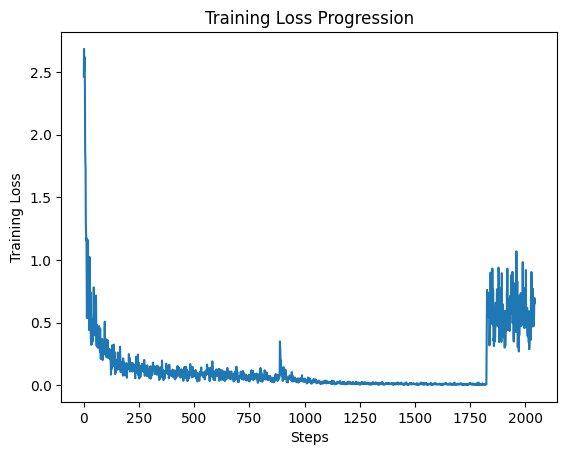

In [ ]:
import matplotlib.pyplot as plt

import transformers
transformers.logging.set_verbosity_debug()
transformers.utils.logging.enable_default_handler()

def main():
  # Set environment variables for debugging
  os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
  os.environ['TORCH_USE_CUDA_DSA'] = "1"

  # Print CUDA and PyTorch version info
  # print(f"PyTorch version: {torch.__version__}")
  # print(f"CUDA version: {torch.version.cuda}")
  # print(f"CUDA available: {torch.cuda.is_available()}")

  # # Check GPU memory status
  # print(torch.cuda.memory_summary())

  # # Print model, args, dataset, and loss for inspection
  # print("Model:", model)
  # print("Args:", args)
  # print("Dataset:", dataset)
  # print("Loss:", loss)

  # Proceed with trainer initialization
  try:
      # Restart Session using the commented lines if this cell fails.
      # import os
      # os._exit(00)
      trainer = SentenceTransformerTrainer(
          model=model,
          args=args,
          train_dataset=dataset,
          loss=loss,
          eval_dataset=test_dataset,
          evaluator=None,
      )
      trainer.add_callback(transformers.ProgressCallback)
      print("Trainer initialized successfully.")
      # Proceed with training
      trainer.train()
      model.save_pretrained("/content/drive/MyDrive/Date Aware Embeddings Model/timely-snowflake-arctic-embed-s-v9")
      print("Model saved successfully.")

      # Plot model training
      # After training is complete
      log_history = trainer.state.log_history

      # Extract training loss
      train_loss = [log['loss'] for log in log_history if 'loss' in log]
      steps = range(len(train_loss))

      # Plot training loss
      plt.plot(steps, train_loss)
      plt.xlabel('Steps')
      plt.ylabel('Training Loss')
      plt.title('Training Loss Progression')
      plt.show()

  except RuntimeError as e:
      print("Caught RuntimeError:", e)
      print("Potential issue with CUDA kernel execution.")
if __name__ == "__main__":
    main()

In [ ]:
#!cp -r "/content/models/timely-snowflake-arctic-embed-s/checkpoint-12000" "/content/drive/MyDrive/Date Aware Embeddings Model/timely-snowflake-arctic-embed-s_v3-12k"

In [ ]:
import os
os.kill(os.getpid(), 9)